# Probabilistic matrix factorization

The used function can be found in the PMF.py script

In [1]:
% matplotlib inline
from PMF import *

The data in this example consists of a set of ratings of 100 jokes, by 100 users. For demonstration purposes, all of the chosen users have rated the jokes.

In [2]:
DATA_DIR = './jester_dataset_1_1/'

data = pd.read_csv(os.path.join(DATA_DIR, 'jester-data.csv'), header=None)

### Training and test sets

The trainig and test sets were previously created from the jester data set by randomly choosing matrix possitions for testing purposes while leaving those possitions empty in the training set

In [3]:
train, test = load_train_test('cdf23eff0f78e353f72fad0f568b98d6d7f12fac')

## 5 factor model

In the model function a structure is defined for the problem of matrix factorization in which an observed matrix $ R$, can be described as:

$$ R = VU^T$$

In which a prior is defined for $ R, V, U$, as:

$$ P(R\rvert U,V,\alpha²)=\prod_{i=1}^N\prod_{j=1}^M[\mathcal{N}(R_{ij}\rvert U_iV_j^T,\alpha^{-1}]^{I_{ij}}$$

Where $ I_{ij}$ indicates the presence of a value (1) or its absence (0).

$$ P(U\rvert \alpha_u²)=\prod_{i=1}^N\mathcal{N}(U_i\rvert 0,\alpha_u^{-1}\textbf{I})$$

$$ P(V\rvert \alpha_v²)=\prod_{j=1}^M\mathcal{N}(V_j\rvert 0,\alpha_v^{-1}\textbf{I})$$

And a first estimation is made using the MAP method.

In [4]:
#The model is created with 5 dimensions (rank 4)
pmf5 = models(5, train)
with pmf5:
    # A MAP estimation is found using 5 dimensions and it is then saved for future use
    mape5 = pm.find_MAP(fmin=sp.optimize.fmin_powell)
save_np_vars(mape5, './jester_dataset_1_1/pmf-map-d5')

INFO:root:building the PMF model
INFO:root:writing numpy vars to directory: ./jester_dataset_1_1/pmf-map-d5


Optimization terminated successfully.
         Current function value: 1546996.514738
         Iterations: 18
         Function evaluations: 895309


## Sampling

The probability distributions previously found with the MAP method are sampled using the classic Metropolis Hastings method

In [5]:
with pmf5:
    step = pm.Metropolis()
    backend = pm.backends.Text('./jester_dataset_1_1/pmf-mcmc-d5/')
    trace5m = pm.sample(draws=200, trace=backend, njobs=2, step=step)

100%|██████████| 200/200 [00:06<00:00, 32.87it/s]


The Frobenius norm is calculated for each of the sampled matrices in the chain to ensure convergence. After a certain number of iterations the norm should be stables, pointing at little changes to the matrices themselves

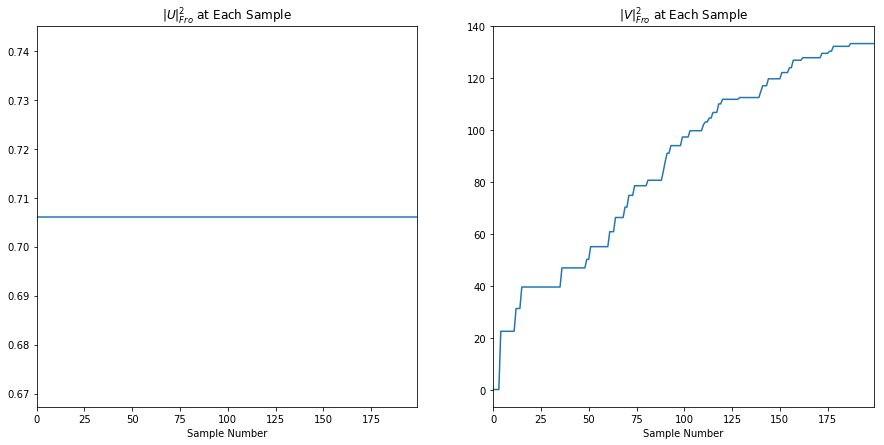

In [6]:
traceplot(trace5m)

## RMSE

The RMSE is a measure of how much the model deviates from the true observation. A comparison can be made between the testing and training predictions to ensure there is not overfitting.

In general the RMSE is calculated as:

$$ RMSE =\sqrt{\frac{\sum_{i=1}^N\sum_{j=1}^M(R_{ij}I_{ij}-\hat{R_{ij}})²}{\sum_{i=1}^N\sum_{j=1}^MI_{ij}}}$$

Where $ \hat{R_{ij}}$ is the prediction for the given observation.

This calculations are performed by the *running_rmse* and *rmse* functions.

In [7]:
predicted5m, results5m = running_rmse(trace5m, test, train, plot=False)

## Hamiltonian Montecarlo

The same sampling process is repeated using the Hamiltonian Montecarlo algorithm in which the formalism of the Hamiltonian in classical mechanics is used to ensure minimum variations along the parameter space in high dimension

In [8]:
with pmf5:
    step = pm.HamiltonianMC()
    backend = pm.backends.Text('./jester_dataset_1_1/pmf-hmcmc-d5/')
    trace5h = pm.sample(draws=200, trace=backend, njobs=2, step=step)

100%|██████████| 200/200 [00:46<00:00,  4.45it/s]


The convergence of the chain using this method is much faster and little variation is observed in the norm, which indicates litlle sensitivity to outliers

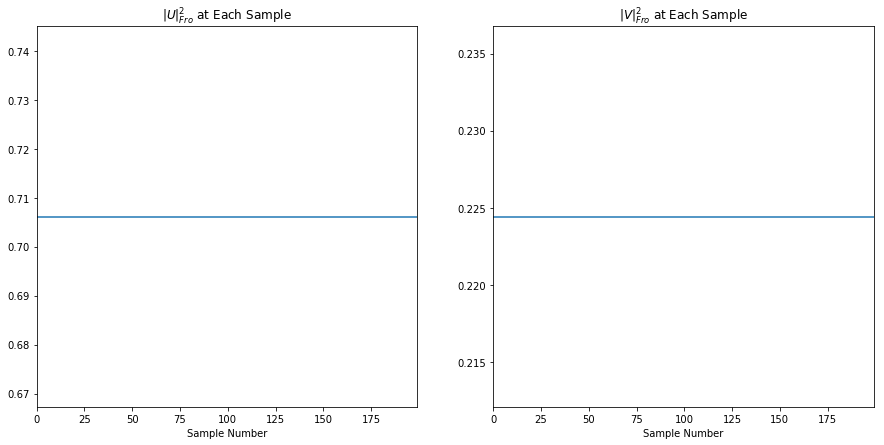

In [9]:
traceplot(trace5h)

In [10]:
predicted5h, results5h = running_rmse(trace5h, test, train, plot=False)

In general the Hamiltonian sampling gives a closer fit to the testing set which indicates a good model without overfitting

PMF MAP training RMSE: 3.92164
PMF MAP testing RMSE:  4.19998
Train/test difference: 0.27834


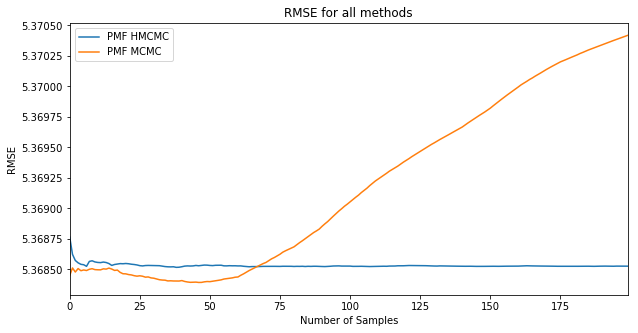

In [11]:
size = 200  # RMSE doesn't really change after 100th sample anyway.
pmf_map_rmse = eval_map(mape5, train, test)
all_results = pd.DataFrame({
    'PMF MCMC': results5m['running-test'][:size],
    'PMF HMCMC': results5h['running-test'][:size]
})
fig, ax = plt.subplots(figsize=(10, 5))
all_results.plot(kind='line', grid=False, ax=ax,
                 title='RMSE for all methods')
ax.set_xlabel("Number of Samples")
ax.set_ylabel("RMSE")

## 10 factor model

In this model the results are very similar to the 5 factor case, and the Hamiltonian sampling algorithm delivers better results in terms of stability

In [12]:
pmf10 = models(10, train)
with pmf10:
    mape10 = pm.find_MAP(fmin=sp.optimize.fmin_powell)
save_np_vars(mape10, './jester_dataset_1_1/pmf-map-d10')

INFO:root:building the PMF model
INFO:root:writing numpy vars to directory: ./jester_dataset_1_1/pmf-map-d10


Optimization terminated successfully.
         Current function value: 1375026.133922
         Iterations: 38
         Function evaluations: 3781125


In [13]:
with pmf10:
    step = pm.Metropolis()
    backend = pm.backends.Text('./jester_dataset_1_1/pmf-mcmc-d10/')
    trace10m = pm.sample(draws=200, trace=backend, njobs=2, step=step)

100%|██████████| 200/200 [00:10<00:00, 18.93it/s]


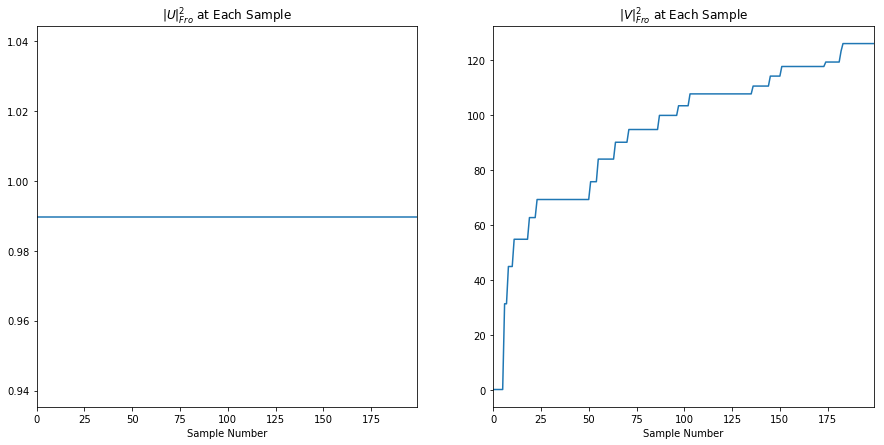

In [14]:
traceplot(trace10m)

In [15]:
predicted10m, results10m = running_rmse(trace10m, test, train, plot=False)

In [16]:
with pmf10:
    step = pm.HamiltonianMC()
    backend = pm.backends.Text('./jester_dataset_1_1/pmf-hmcmc-d10/')
    trace10h = pm.sample(draws=200, trace=backend, njobs=2, step=step)

100%|██████████| 200/200 [01:00<00:00,  5.14it/s]


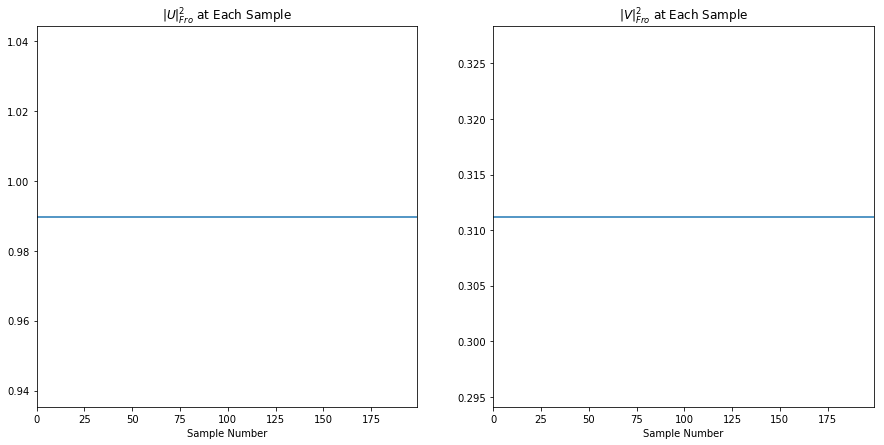

In [17]:
traceplot(trace10h)

In [18]:
predicted10h, results10h = running_rmse(trace10h, test, train, plot=False)

PMF MAP training RMSE: 3.64138
PMF MAP testing RMSE:  4.19607
Train/test difference: 0.55468


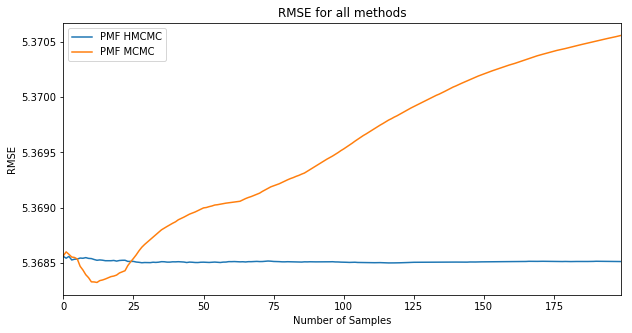

In [19]:
size = 200  # RMSE doesn't really change after 100th sample anyway.
pmf_map_rmse = eval_map(mape10, train, test)
all_results = pd.DataFrame({
    'PMF MCMC': results10m['running-test'][:size],
    'PMF HMCMC': results10h['running-test'][:size]
})
fig, ax = plt.subplots(figsize=(10, 5))
all_results.plot(kind='line', grid=False, ax=ax,
                 title='RMSE for all methods')
ax.set_xlabel("Number of Samples")
ax.set_ylabel("RMSE")

## 20 factor model

This model serves as a somewhat extrem comparison between the classic Metropolis Hastings method and the Hamiltonian Montecarlo Method when a grea number of variables are tobe estimated and sampled

In [20]:
pmf20 = models(20, train)
with pmf20:
    mape20 = pm.find_MAP(fmin=sp.optimize.fmin_powell)
save_np_vars(mape20, './jester_dataset_1_1/pmf-map-d20')

INFO:root:building the PMF model
INFO:root:writing numpy vars to directory: ./jester_dataset_1_1/pmf-map-d20


Optimization terminated successfully.
         Current function value: 1137775.552133
         Iterations: 38
         Function evaluations: 7562617


In [21]:
with pmf20:
    step = pm.Metropolis()
    backend = pm.backends.Text('./jester_dataset_1_1/pmf-mcmc-d20/')
    trace20m = pm.sample(draws=200, trace=backend, njobs=2, step=step)

100%|██████████| 200/200 [00:12<00:00, 20.33it/s]


In this case, convergence cannot be ensured, making it necessary to take a greater number of samples

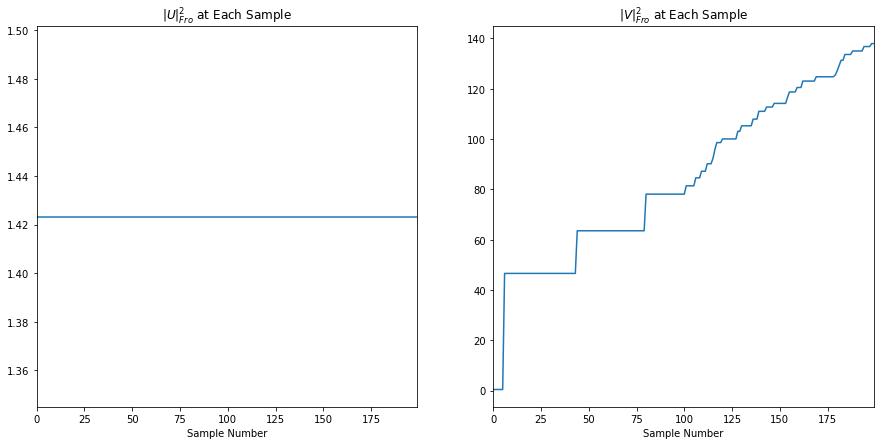

In [22]:
traceplot(trace20m)

In [23]:
predicted20m, results20m = running_rmse(trace20m, test, train, plot=False)

In [24]:
with pmf20:
    step = pm.HamiltonianMC()
    backend = pm.backends.Text('./jester_dataset_1_1/pmf-hmcmc-d20/')
    trace20h = pm.sample(draws=200, trace=backend, njobs=2, step=step)

100%|██████████| 200/200 [01:19<00:00,  4.88it/s]


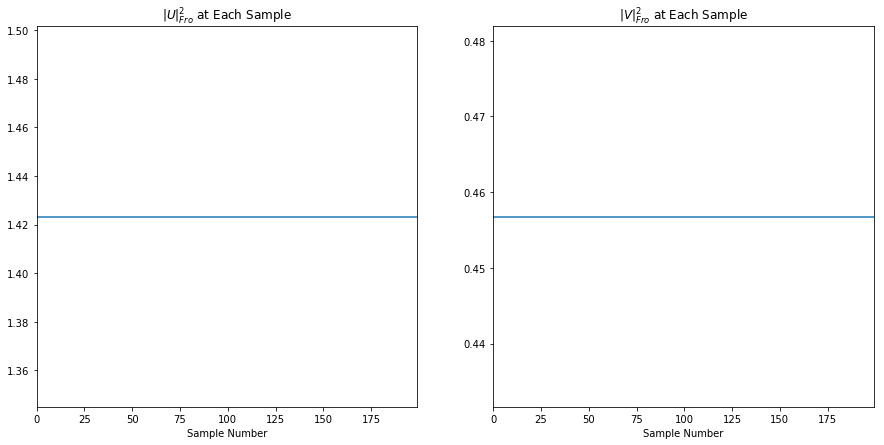

In [25]:
traceplot(trace20h)

In [28]:
predicted20h, results20h = running_rmse(trace20h, test, train, plot=False)

The RMSE value in this case is slightly better for the classic Metropolis Hastings case, however the stability of the chain is not ensured.

PMF MAP training RMSE: 3.64131
PMF MAP testing RMSE:  4.19602
Train/test difference: 0.55471


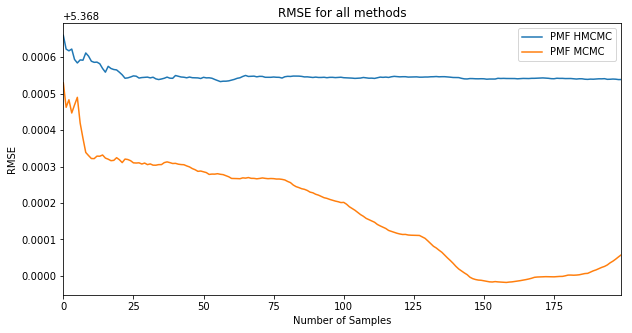

In [27]:
size = 200  # RMSE doesn't really change after 100th sample anyway.
pmf_map_rmse = eval_map(mape10, train, test)
all_results = pd.DataFrame({
    'PMF MCMC': results20m['running-test'][:size],
    'PMF HMCMC': results20h['running-test'][:size]
})
fig, ax = plt.subplots(figsize=(10, 5))
all_results.plot(kind='line', grid=False, ax=ax,
                 title='RMSE for all methods')
ax.set_xlabel("Number of Samples")
ax.set_ylabel("RMSE")

## Disclaimer

This notebook is based on the example found in https://pymc-devs.github.io/pymc3/notebooks/pmf-pymc.html by the developers of PyMC3